In [1]:
import scipy.io as sio

In [2]:
matfile = '/run/media/nfarrugi/ECHACHACHOU/PD_phase/data_probands_beta_noselec_p50_Cz_6_Hz.mat'

In [3]:
filecontents = sio.whosmat(matfile)
print(filecontents)

[('plv_subj_01k1', (1, 1), 'struct'), ('plv_subj_02k1', (1, 1), 'struct'), ('plv_subj_03k1', (1, 1), 'struct'), ('plv_subj_04k1', (1, 1), 'struct'), ('plv_subj_05k1', (1, 1), 'struct'), ('plv_subj_06k1', (1, 1), 'struct'), ('plv_subj_07k1', (1, 1), 'struct'), ('plv_subj_08k1', (1, 1), 'struct'), ('plv_subj_09k1', (1, 1), 'struct'), ('plv_subj_10k1', (1, 1), 'struct'), ('plv_subj_11k1', (1, 1), 'struct'), ('plv_subj_12k1', (1, 1), 'struct'), ('plv_subj_13k1', (1, 1), 'struct'), ('plv_subj_14k1', (1, 1), 'struct'), ('plv_subj_15k1', (1, 1), 'struct'), ('plv_subj_16k1', (1, 1), 'struct'), ('plv_subj_17k1', (1, 1), 'struct'), ('plv_subj_18k1', (1, 1), 'struct'), ('plv_subj_19k1', (1, 1), 'struct'), ('plv_subj_20k1', (1, 1), 'struct')]


Let's pick one subject randomly

In [4]:
import numpy as np 

cursubjname = filecontents[np.random.randint(20)][0]
print(cursubjname)

plv_subj_15k1


Load this subject

In [5]:
subjdata = sio.loadmat(matfile,variable_names=cursubjname,struct_as_record = False,squeeze_me=True)[cursubjname]

We can now directly access all the fields of the struct directly like in Matlab

Let's first select a particular time point to start with, say, 50 ms

In [6]:
subjdata.all.iso.standard.time[125]

0.049999999998811967

Seems to correspond to time point 125. Now let's create an array with all phases at this time point, at Cz, for one condition (Iso std) 

In [7]:
subjdata.all.iso.standard.label

array(['Fz', 'Cz', 'Pz'], dtype=object)

Cz is label 1 

In [8]:
p50_cz_iso_std = subjdata.all.iso.standard.ang[:,1,:,125]

In [9]:
p50_cz_iso_std.shape

(176, 51)

Trials are n_samples, and n_features is the number of frequencies. 

Do the same for RND std

In [10]:
p50_cz_rnd_std = subjdata.all.rnd.standard.ang[:,1,:,125]
p50_cz_rnd_std.shape

(213, 51)

Build the y vector (will be 1 for iso and 2 for rnd)

In [11]:
n_iso = p50_cz_iso_std.shape[0]
n_rnd = p50_cz_rnd_std.shape[0]
print(n_iso,n_rnd)

y = 2*np.ones(n_iso+n_rnd)
y[0:n_iso]=1

176 213


Build the X vector by just concatenating vertically the previous ones 

In [12]:
X = np.vstack([p50_cz_iso_std,p50_cz_rnd_std])
print(X.shape)

(389, 51)


In [13]:
from matplotlib import pyplot as plt 
%matplotlib inline

Let's quickly have a look at the distributions before doing decoding

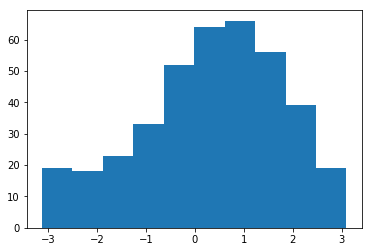

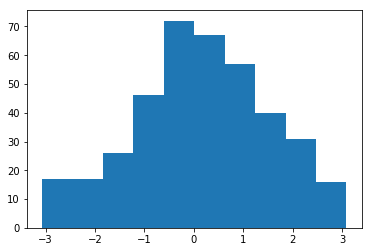

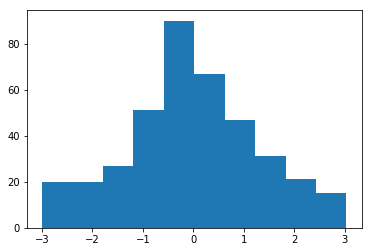

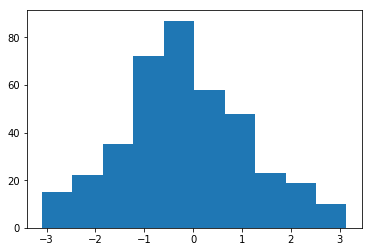

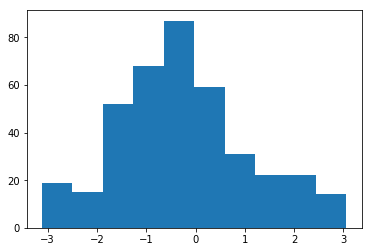

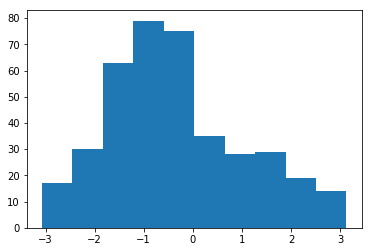

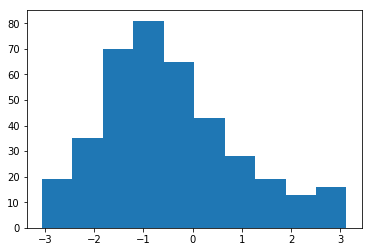

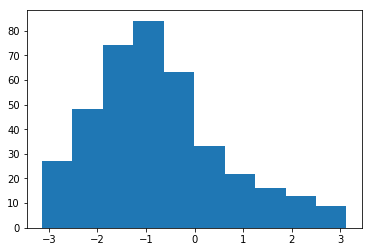

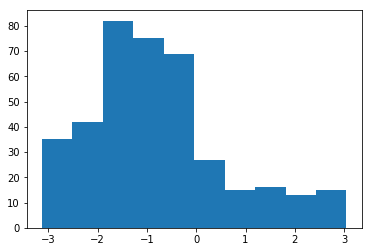

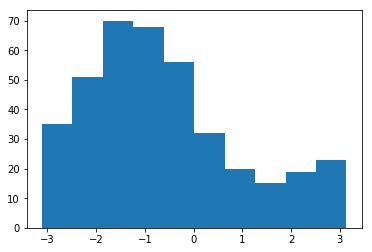

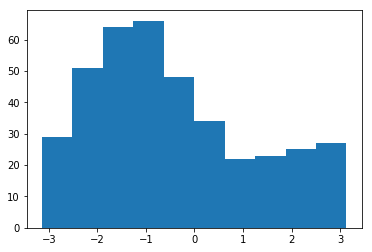

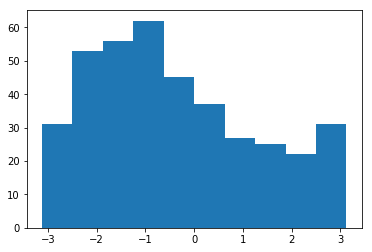

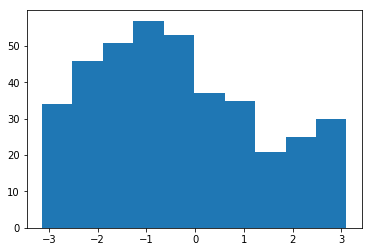

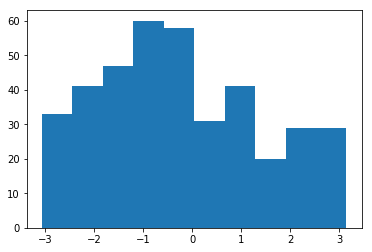

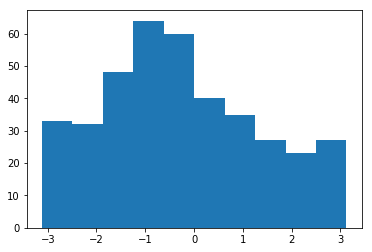

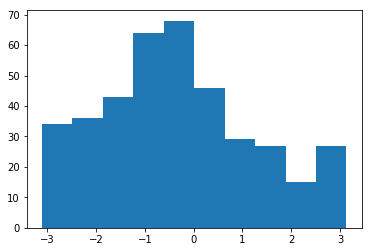

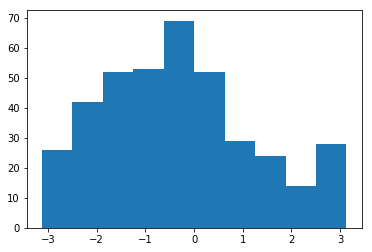

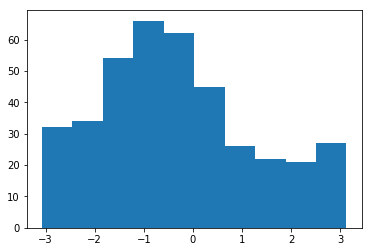

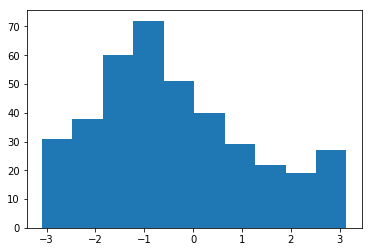

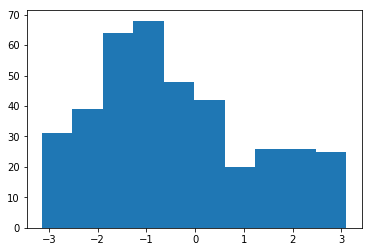

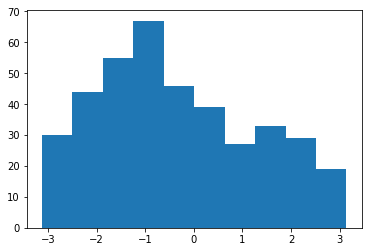

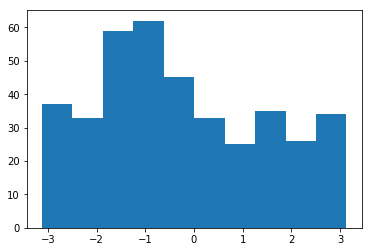

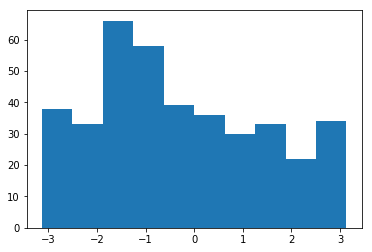

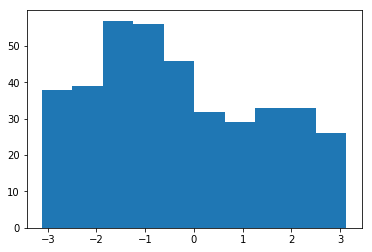

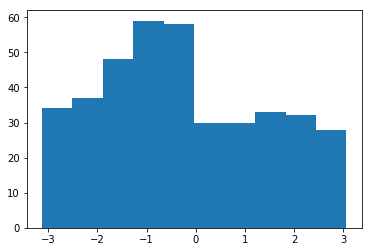

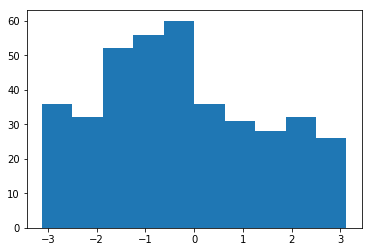

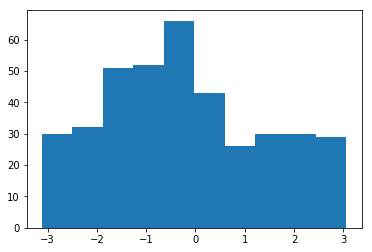

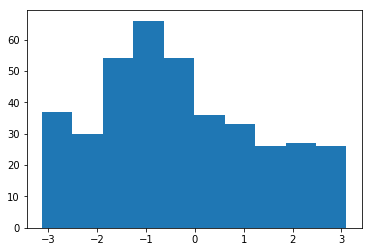

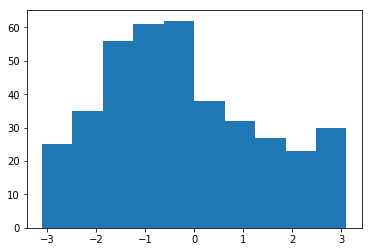

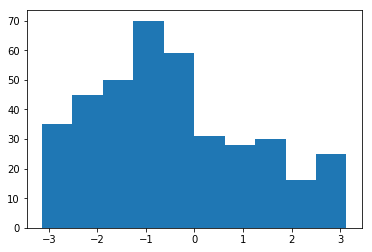

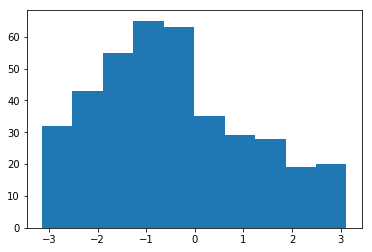

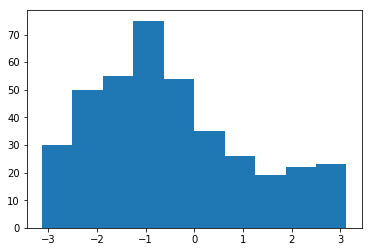

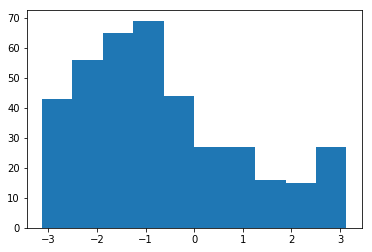

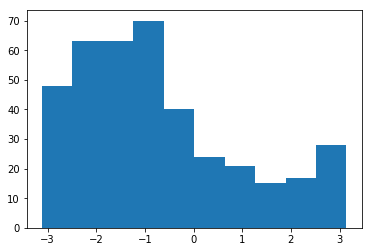

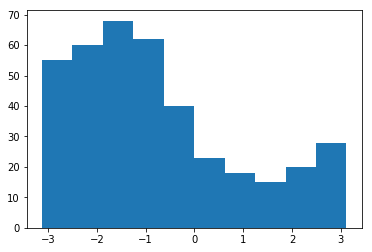

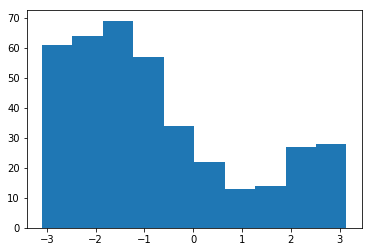

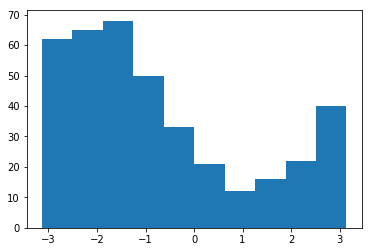

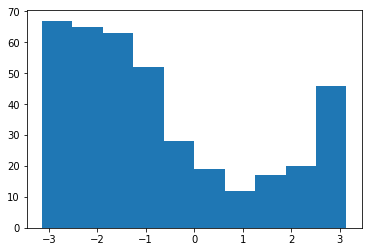

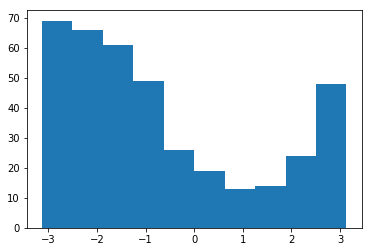

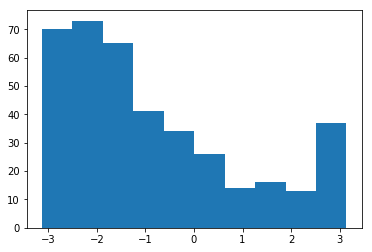

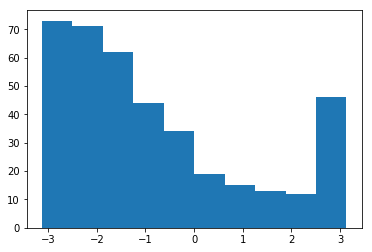

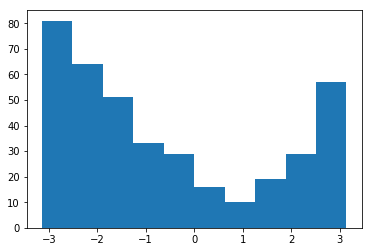

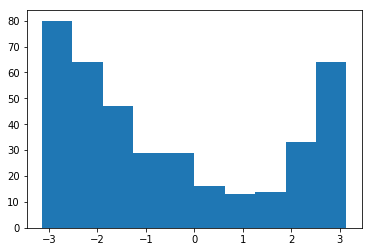

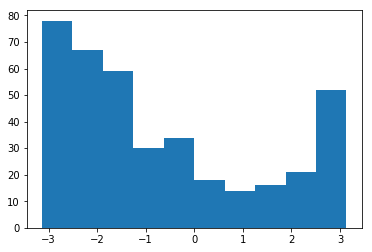

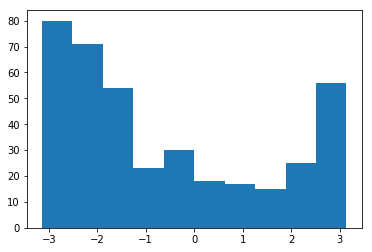

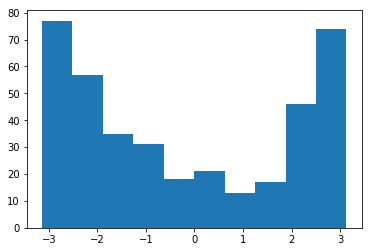

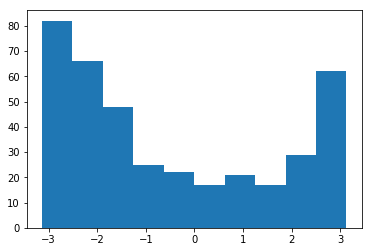

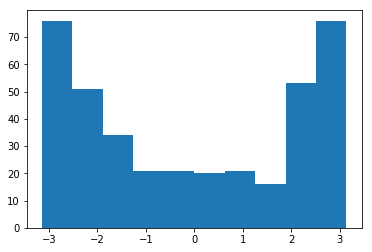

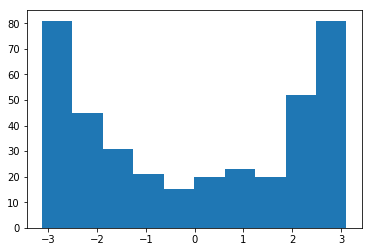

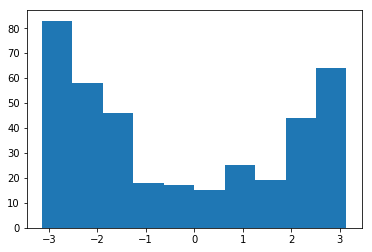

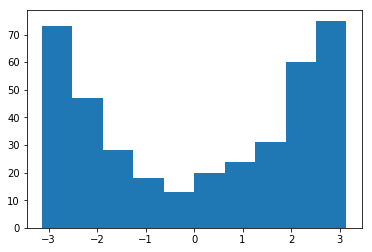

In [14]:
for curX in X.T:
    plt.hist(curX)
    plt.show()

It looks like for the high frequencies, the distributions are far from normal. Let's do the same by separating conditions 

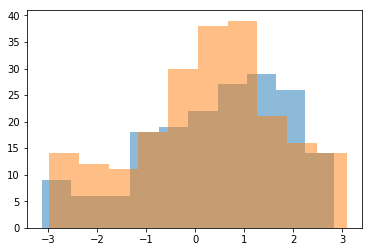

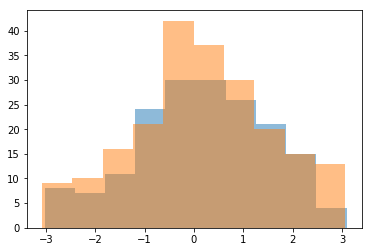

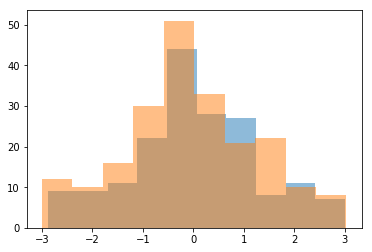

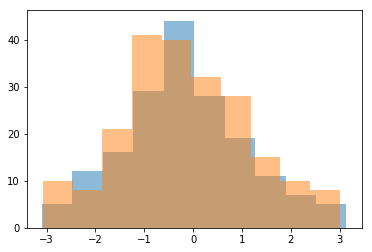

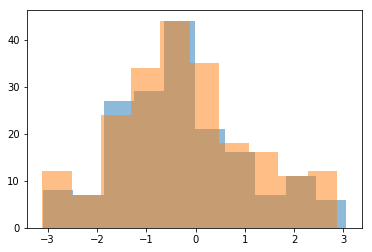

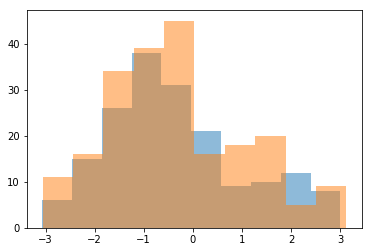

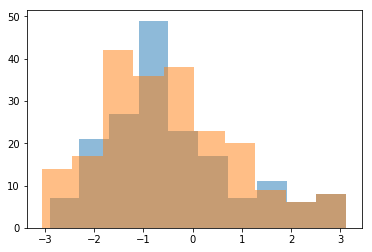

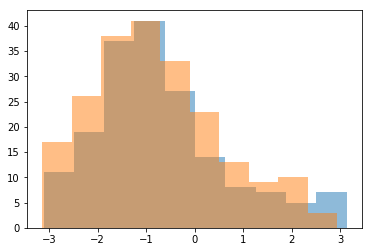

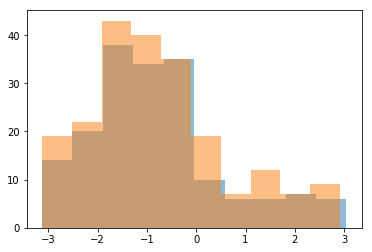

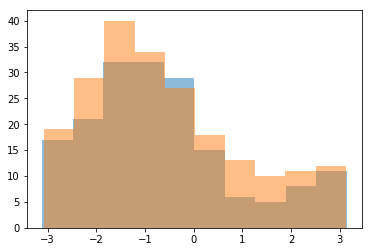

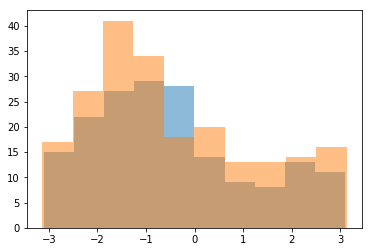

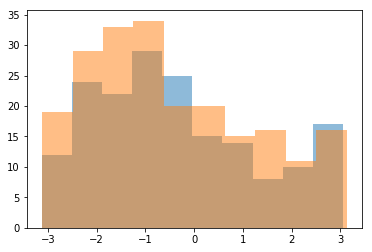

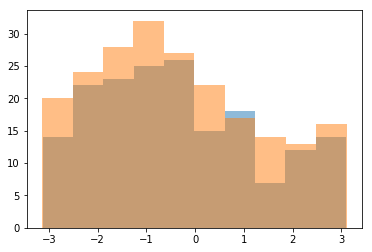

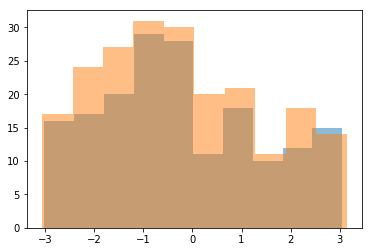

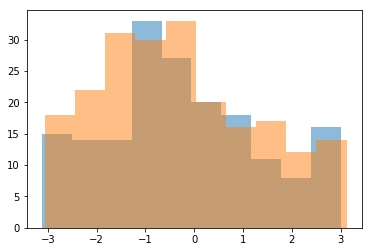

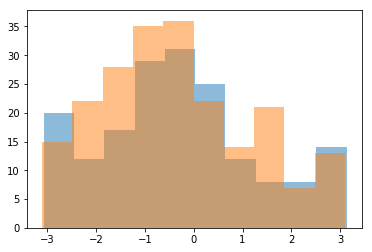

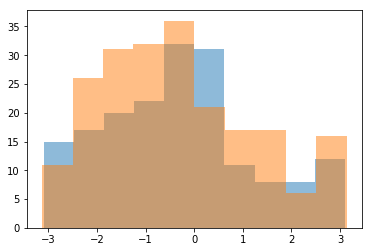

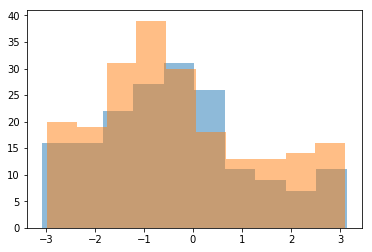

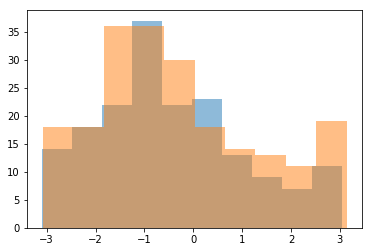

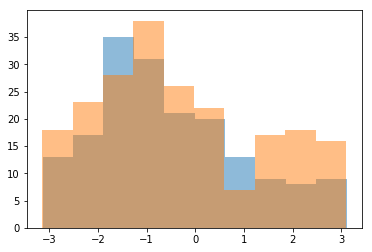

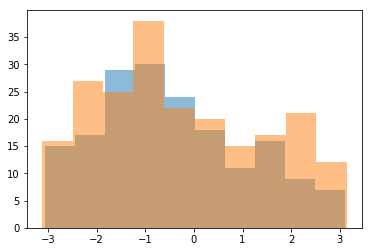

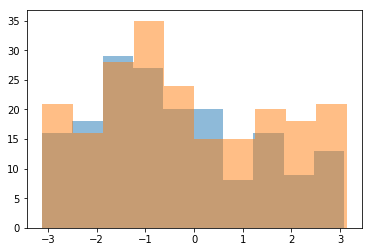

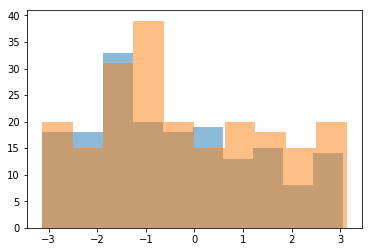

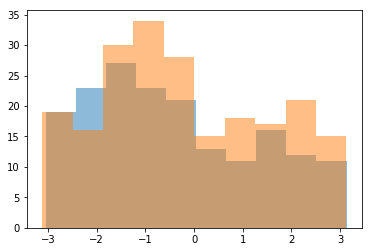

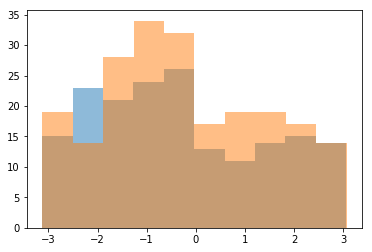

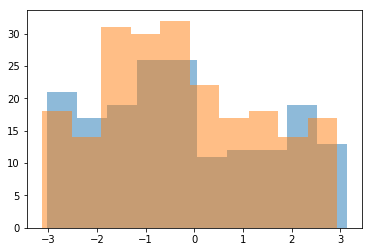

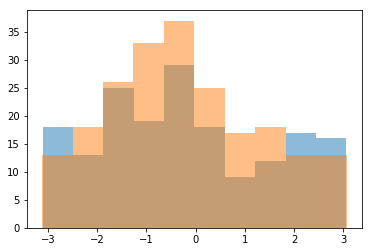

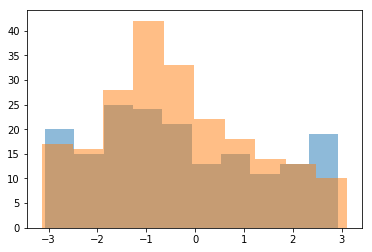

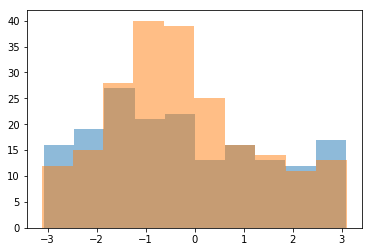

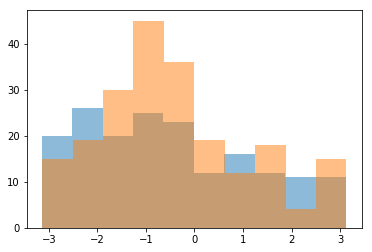

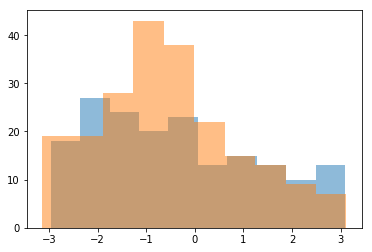

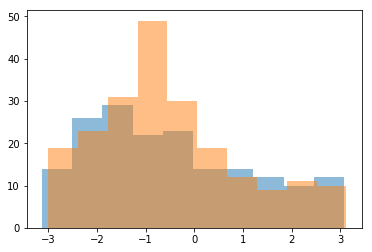

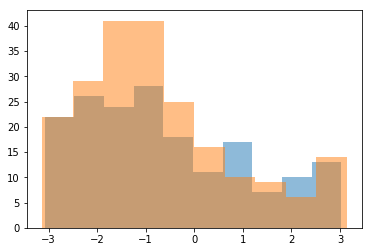

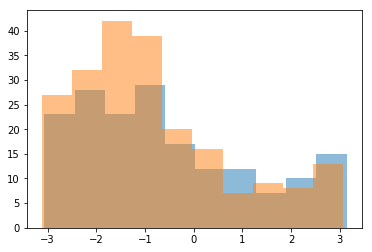

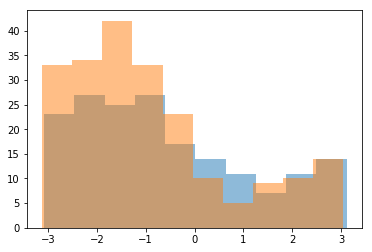

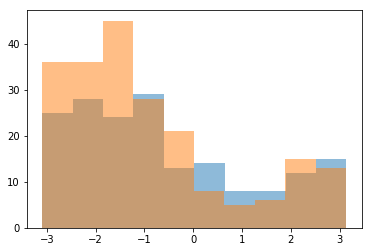

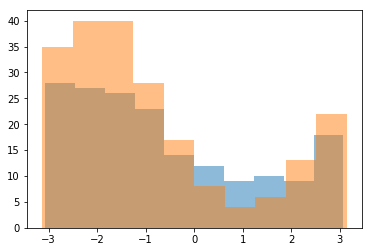

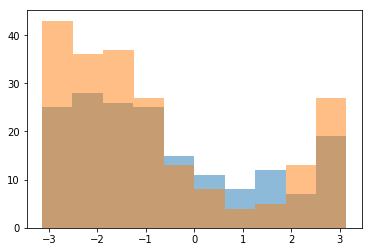

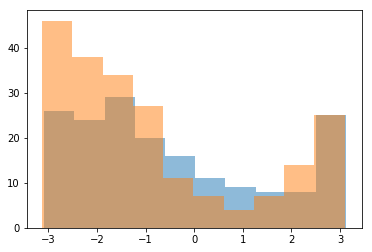

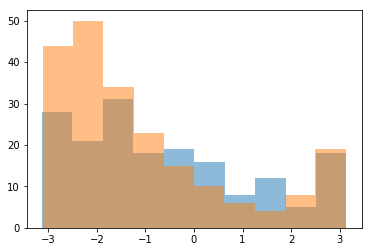

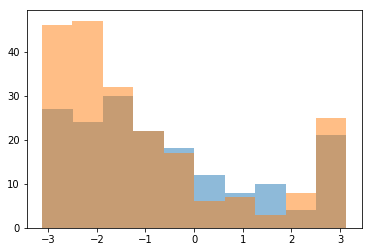

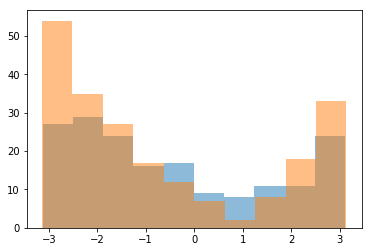

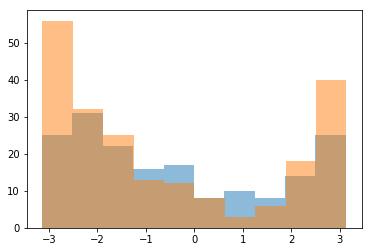

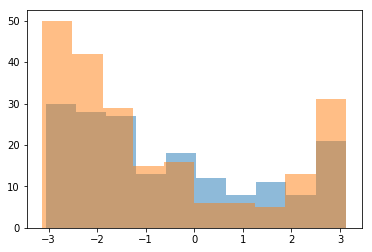

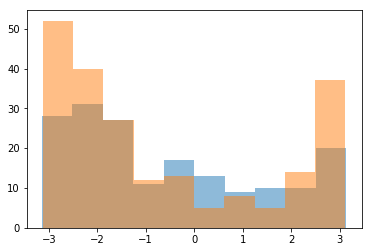

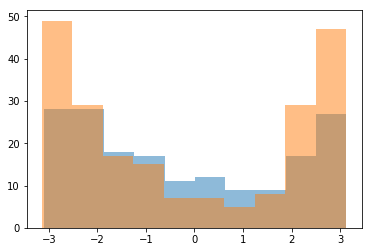

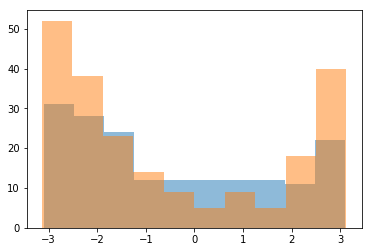

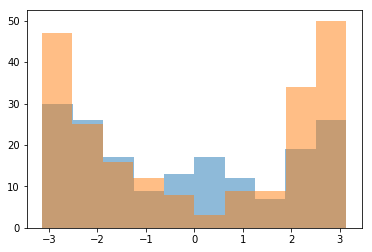

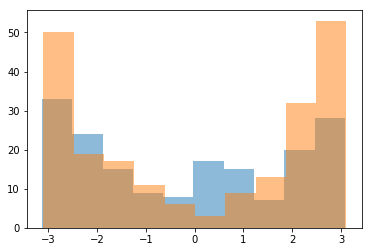

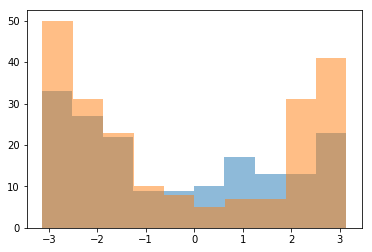

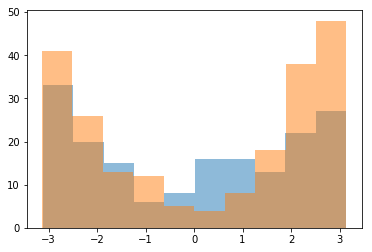

In [15]:
for curX1,curX2 in zip(p50_cz_iso_std.T,p50_cz_rnd_std.T):
    plt.hist(curX1,alpha=0.5)
    plt.hist(curX2,alpha=0.5)
    plt.show()

There may be a few features that are discriminative. Let's try to train a classifier

In [17]:
from sklearn.model_selection  import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [24]:
X_train.shape,X_test.shape

((311, 51), (78, 51))

In [51]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,QuantileTransformer
from sklearn.metrics import accuracy_score


In [68]:
scaler = StandardScaler()
quantiler = QuantileTransformer(n_quantiles=100,output_distribution='normal')

svm= SVC(C=1., kernel="rbf")

my_nn = KNeighborsClassifier()
k=50
feature_selection = SelectKBest(f_classif, k=k)

#pipeline_anova = Pipeline([('anova', feature_selection), ('scale', scaler),('classif_name', svm)])
pipeline_anova = Pipeline([('scale', quantiler),('classif_name', svm)])

## Train 

pipeline_anova.fit(X_train,y_train)

## and test

y_pred = pipeline_anova.predict(X_test)

accuracy_score(y_true=y_test,y_pred=y_pred)


0.57692307692307687